In [43]:
!pip install category_encoders


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Step 1: Import all the necessary libraries

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder 
import shap

In [45]:
df = pd.read_csv("prepared_orders_data.csv")

In [46]:
df.head()

,Unnamed: 0_x,Customer_Key,Order_Key,order_source,created_at,dispatch_time,actual_delivery_time,bill_amount,cart_amount,coupon_id,...,discount_amount,manhattan_distance,distance_bucket,pdt_bucket,delivery_fee_bucket,order_status,Unnamed: 0_y,customer_id,start_date,end_date
0,1,CUST_1,ORD_1,Mobile,2024-03-01 03:33:35,NaN,NaN,263,199.0,8043589.0,...,-34.60,0.012400,Close (20-40%),41-50min,21-40,Cancelled,59066.0,CUST_1,2024-03-01 03:54:52,2024-08-28 03:54:52
1,2,CUST_2,ORD_2,Mobile,2024-03-01 03:55:46,2024-03-01 04:12:56,2024-03-01 04:22:16,341,417.0,7670379.0,...,85.45,0.005154,Very Close (0-20%),41-50min,1-20,Delivered,NaN,NaN,NaN,NaN
2,3,CUST_3,ORD_3,Mobile,2024-03-01 04:37:43,2024-03-01 04:47:54,2024-03-01 04:59:28,180,228.0,7987325.0,...,48.00,0.024976,Far (60-80%),31-40min,Free (0),Delivered,37322.0,CUST_3,2024-03-01 04:18:56,2024-08-28 04:18:56
3,4,CUST_4,ORD_4,Mobile,2024-03-01 04:37:58,2024-03-01 04:56:32,2024-03-01 05:20:58,541,557.0,7987325.0,...,16.00,0.022578,Medium (40-60%),41-50min,Free (0),Delivered,26946.0,CUST_4,2024-02-06 04:09:59,2024-08-04 04:09:59
4,5,CUST_5,ORD_5,Mobile,2024-03-01 04:40:33,NaN,NaN,238,219.0,8043589.0,...,-19.00,0.032478,Far (60-80%),41-50min,Free (0),Cancelled,NaN,NaN,NaN,NaN


In [47]:
df.columns

Index(['Unnamed: 0_x', 'Customer_Key', 'Order_Key', 'order_source',
       'created_at', 'dispatch_time', 'actual_delivery_time', 'bill_amount',
       'cart_amount', 'coupon_id', 'delivery_fee', 'store_key',
       'delivery_city', 'pdt', 'Store_lat', 'Store_long',
       'delivery_location_latitude', 'delivery_location_longitude',
       'pay_mode_grouped', 'is_cancelled', 'order_hour', 'order_day',
       'order_date', 'is_loyalty', 'used_coupon', 'discount_amount',
       'manhattan_distance', 'distance_bucket', 'pdt_bucket',
       'delivery_fee_bucket', 'order_status', 'Unnamed: 0_y', 'customer_id',
       'start_date', 'end_date'],
      dtype='object')

#### Step 2:  Data cleanup to remove bangalore stores, calculate and add columns like discount amount, short term cutomers etc.

In [48]:
#Initial data cleaning and prep as per the announcement
# Check for stores with latitude between 12 and 13 as provided in announcement to ignore
# Remove them
df = df[~((df['Store_lat'] >= 12) & (df['Store_lat'] <= 13))]

# Add discount amount as Discount =  Cart Amount - (Bill Amount - Delivery Fees)/1.05
df['Discount'] = df['cart_amount'] - (df['bill_amount'] - df['delivery_fee']) / 1.05


#Check the start_date and end_date columns to classify customers as new or returning
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])   
df['subscription_ended_in_a_week'] = (df['end_date'] - df['start_date']).dt.days <= 7

# add customer tenure and bucket them
df['customer_tenure_days'] = (df['end_date'] - df['start_date']).dt.days
def tenure_bucket(days):
    if days < 30:
        return '0-30 days'
    elif days < 90:
        return '31-90 days'
    elif days < 180:
        return '91-180 days'
    else:
        return '180+ days'

df['tenure_bucket'] = df['customer_tenure_days'].apply(tenure_bucket)

#add order_month column from order_date
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_month'] = df['order_date'].dt.month

#### Step 3 : Check target distribution to observe class imbalance

In [49]:
#Check target column distribution
target_col = "is_cancelled"
df['is_cancelled'] = df['is_cancelled'].apply(lambda x: 1 if x == True else 0)
df['is_cancelled'].value_counts()

is_cancelled
0    475964
1     95399
Name: count, dtype: int64

#### Step 4: Remove unwanted columns that are not valid predictors or columns that cause target leakage

In [50]:
target_col = "is_cancelled"
X = df.drop(columns=[target_col,
                     'Unnamed: 0_x',
                     'Unnamed: 0_y',
                     'start_date',
                     'end_date',
                     'Order_Key',
                    'created_at',
                    'coupon_id',
                    'Store_lat', 
                    'Store_long', 
                    'delivery_location_latitude', 
                    'delivery_location_longitude',
                    'customer_id',
                    'Customer_Key',
                    'order_date',
                    'actual_delivery_time',
                    'order_status',
                    'dispatch_time'
                     ])
y = df[target_col]

#### Split the dataset into training and test

In [51]:
def data_split(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test


In [52]:

X_train, X_test, y_train, y_test = data_split(X, y)

In [53]:
def get_numerical_categorical_columns(X):
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
    return numerical_cols, categorical_cols

In [54]:
numerical_cols, categorical_cols = get_numerical_categorical_columns(X_train)

#### Create a preprocessing pipeline for imputing, scaling and encoding

In [55]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

# Baseline model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

baseline_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg)
])


#### Baseline Classifier

In [56]:
baseline_clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
def validate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(report)

In [58]:
validate_model(baseline_clf, X_test, y_test)

ROC AUC Score: 0.6770
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72     95193
           1       0.24      0.64      0.35     19080

    accuracy                           0.61    114273
   macro avg       0.57      0.62      0.53    114273
weighted avg       0.78      0.61      0.66    114273



#### Creating feature engineer pipelines to enhance the model

In [59]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Add domain-specific engineered features for cancel prediction.
    Assumes input is a pandas DataFrame with the given columns.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Safe divisions: avoid divide-by-zero
        cart_safe = X['cart_amount'].replace(0, np.nan)
        bill_safe = X['bill_amount'].replace(0, np.nan)

        # Discount ratio relative to cart value
        X['discount_ratio'] = (X['discount_amount'] / cart_safe).fillna(0)

        # Effective order value (you can tweak this based on your business meaning)
        X['effective_order_value'] = (
            X['bill_amount'] + X['delivery_fee'] - X['discount_amount']
        )

        # Delivery fee as fraction of bill
        X['fee_to_bill_ratio'] = (X['delivery_fee'] / bill_safe).fillna(0)

        # Distance × promised time (proxy for delivery difficulty)
        X['distance_time'] = X['manhattan_distance'] * X['pdt']

        # Late night (22:00–03:59)
        X['is_late_night'] = X['order_hour'].isin([22, 23, 0, 1, 2, 3]).astype(int)

        # Peak meal times (lunch/dinner)
        X['is_peak_meal'] = X['order_hour'].isin([11, 12, 13, 19, 20, 21]).astype(int)

        # Log of tenure
        X['tenure_log'] = np.log1p(X['customer_tenure_days'].clip(lower=0))

        return X


#### Apply appropriate categorical encoding based on the cardinality of the columns

In [60]:
def detect_column_types(X, low_card_max_unique: int = 15):
    """
    Automatically detect:
      - numeric columns
      - low-cardinality categoricals (<= low_card_max_unique)
      - high-cardinality categoricals (> low_card_max_unique)
    """
    # numeric vs categorical
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # cardinality of categoricals
    cardinality = X[cat_cols].nunique()

    low_card_cat = cardinality[cardinality <= low_card_max_unique].index.tolist()
    high_card_cat = cardinality[cardinality > low_card_max_unique].index.tolist()

    return num_cols, low_card_cat, high_card_cat


In [61]:
def build_preprocessor(X_sample: pd.DataFrame, low_card_max_unique: int = 15):
    """
    Build a ColumnTransformer based on automatic detection of column types and cardinality
    using a sample DataFrame (typically X_train AFTER feature engineering).
    """
    num_cols, low_card_cat, high_card_cat = detect_column_types(
        X_sample,
        low_card_max_unique=low_card_max_unique
    )

    # Numeric pipeline: impute -> interactions -> scale
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('interactions', PolynomialFeatures(
            degree=2,
            interaction_only=True,
            include_bias=False
        )),
        ('scaler', StandardScaler())
    ])

    # Low-cardinality categorical: impute -> one-hot
    low_cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # High-cardinality categorical: impute -> target encode
    high_cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_enc', TargetEncoder(smoothing=0.3))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('low_cat', low_cat_transformer, low_card_cat),
            ('high_cat', high_cat_transformer, high_card_cat),
        ],
        remainder='drop'
    )

    return preprocessor, num_cols, low_card_cat, high_card_cat


In [62]:
def build_model_pipeline(X_train: pd.DataFrame, low_card_max_unique: int = 15):
    """
    X_train: raw training DataFrame with your original columns.
    Returns:
      - pipeline ready for fit(X_train, y_train)
      - metadata about columns
    """
    # 1. Instantiate feature engineering (stateless)
    feat_eng = FeatureEngineer()

    # 2. Apply feature engineering once on X_train to detect final columns
    X_train_fe = feat_eng.fit_transform(X_train)

    # 3. Build preprocessor based on engineered features
    preprocessor, num_cols, low_card_cat, high_card_cat = build_preprocessor(
        X_train_fe,
        low_card_max_unique=low_card_max_unique
    )

    # 4. Final pipeline: FeatureEngineering -> Preprocessing -> Classifier
    clf = LogisticRegression(
        max_iter=500,
        solver='lbfgs',
        class_weight='balanced'
    )

    model = Pipeline(steps=[
        ('feat_eng', feat_eng),
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    metadata = {
        'num_cols': num_cols,
        'low_card_cat': low_card_cat,
        'high_card_cat': high_card_cat
    }

    return model, metadata


In [63]:
# Build pipeline with automatic detection + feature engineering
model, meta = build_model_pipeline(X_train, low_card_max_unique=8)

print("Numeric columns:", meta['num_cols'])
print("Low-card categoricals:", meta['low_card_cat'])
print("High-card categoricals:", meta['high_card_cat'])


Numeric columns: ['bill_amount', 'cart_amount', 'delivery_fee', 'pdt', 'order_hour', 'discount_amount', 'manhattan_distance', 'Discount', 'customer_tenure_days', 'order_month', 'discount_ratio', 'effective_order_value', 'fee_to_bill_ratio', 'distance_time', 'is_late_night', 'is_peak_meal', 'tenure_log']
Low-card categoricals: ['order_source', 'delivery_city', 'order_day', 'is_loyalty', 'used_coupon', 'distance_bucket', 'pdt_bucket', 'delivery_fee_bucket', 'subscription_ended_in_a_week', 'tenure_bucket']
High-card categoricals: ['store_key', 'pay_mode_grouped']


#### Train the  enhanced model and evaluate the metrics

In [64]:
# Fit the model
model.fit(X_train, y_train)

def evaluate_binary_classifier(model, X_tr, y_tr, X_te, y_te, pos_label=1):
    # ---- Train predictions ----
    y_tr_proba = model.predict_proba(X_tr)[:, 1]
    y_tr_pred = model.predict(X_tr)

    # ---- Test predictions ----
    y_te_proba = model.predict_proba(X_te)[:, 1]
    y_te_pred = model.predict(X_te)

    # ---- ROC-AUC ----
    train_roc = roc_auc_score(y_tr, y_tr_proba)
    test_roc = roc_auc_score(y_te, y_te_proba)

    print("\n" + "="*40)
    print("TRAIN PERFORMANCE")
    print("="*40)
    print(f"ROC-AUC (train): {train_roc:.4f}")
    print("\nClassification Report (train):")
    print(classification_report(y_tr, y_tr_pred, digits=4))
    print("Confusion Matrix (train):")
    print(confusion_matrix(y_tr, y_tr_pred))

    print("\n" + "="*40)
    print("TEST PERFORMANCE")
    print("="*40)
    print(f"ROC-AUC (test): {test_roc:.4f}")
    print("\nClassification Report (test):")
    print(classification_report(y_te, y_te_pred, digits=4))
    print("Confusion Matrix (test):")
    print(confusion_matrix(y_te, y_te_pred))

    return {
        "train_roc_auc": train_roc,
        "test_roc_auc": test_roc,
        "y_tr_pred": y_tr_pred,
        "y_tr_proba": y_tr_proba,
        "y_te_pred": y_te_pred,
        "y_te_proba": y_te_proba
    }

# Call the evaluation
metrics = evaluate_binary_classifier(model, X_train, y_train, X_test, y_test)


TRAIN PERFORMANCE
ROC-AUC (train): 0.6874

Classification Report (train):
              precision    recall  f1-score   support

           0     0.8812    0.7397    0.8043    380771
           1     0.2789    0.5024    0.3587     76319

    accuracy                         0.7001    457090
   macro avg     0.5801    0.6210    0.5815    457090
weighted avg     0.7806    0.7001    0.7299    457090

Confusion Matrix (train):
[[281655  99116]
 [ 37977  38342]]

TEST PERFORMANCE
ROC-AUC (test): 0.6858

Classification Report (test):
              precision    recall  f1-score   support

           0     0.8808    0.7399    0.8043     95193
           1     0.2784    0.5005    0.3577     19080

    accuracy                         0.7000    114273
   macro avg     0.5796    0.6202    0.5810    114273
weighted avg     0.7802    0.7000    0.7297    114273

Confusion Matrix (test):
[[70437 24756]
 [ 9531  9549]]


#### Create new pipeline with different domain-specific features

In [65]:
#new pipeline with more features

X_train, X_test, y_train, y_test = data_split(X, y)
X_train, X_val, y_train, y_val = data_split(X_train, y_train, test_size=0.25)  # 0.25 x 0.8 = 0.2

In [66]:
X_train.columns

Index(['order_source', 'bill_amount', 'cart_amount', 'delivery_fee',
       'store_key', 'delivery_city', 'pdt', 'pay_mode_grouped', 'order_hour',
       'order_day', 'is_loyalty', 'used_coupon', 'discount_amount',
       'manhattan_distance', 'distance_bucket', 'pdt_bucket',
       'delivery_fee_bucket', 'Discount', 'subscription_ended_in_a_week',
       'customer_tenure_days', 'tenure_bucket', 'order_month'],
      dtype='object')

In [ ]:



# ============================================================
# 1. Row-level Feature Engineering (no leakage)
# ============================================================

class RowFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Row-wise features that do NOT aggregate over dataset:
      - is_peak_hour / is_lunch / is_dinner
      - season
      - effective_cart_value
      - discount_x_effective_cart_value
      - delivery_fee_x_distance
    Requires:
      - 'order_hour' (int 0–23)
      - 'cart_amount', 'discount_amount'
      - 'delivery_fee', 'manhattan_distance'
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def _month_to_season(self, month):
        #india specific seasons
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5,6]:
            return 'summer'
        elif month in [7, 8,9]:
            return 'monsoon'
        else:
            return 'autumn'

    def transform(self, X):
        X = X.copy()

        # ---------- Time-based flags ----------
        if 'order_hour' in X.columns:
            hour = X['order_hour']

            # Lunch: 11–14, Dinner: 18–21, Peak = both
            X['is_lunch'] = hour.isin([11, 12, 13, 14]).astype(int)
            X['is_dinner'] = hour.isin([18, 19, 20, 21]).astype(int)
            X['is_peak_hour'] = ((X['is_lunch'] == 1) | (X['is_dinner'] == 1)).astype(int)
        else:
            X['is_lunch'] = 0
            X['is_dinner'] = 0
            X['is_peak_hour'] = 0
        
        if 'order_month' in X.columns:
            X['season'] = X['order_month'].map(self._month_to_season).astype('category')
           

        # ---------- Monetary + distance interactions ----------
        if {'cart_amount', 'discount_amount'}.issubset(X.columns):
            eff_cart = X['cart_amount'] - X['discount_amount']
            X['effective_cart_value'] = eff_cart
            X['discount_x_effective_cart_value'] = X['discount_amount'] * eff_cart
        else:
            X['effective_cart_value'] = 0
            X['discount_x_effective_cart_value'] = 0

        if {'delivery_fee', 'manhattan_distance'}.issubset(X.columns):
            X['delivery_fee_x_distance'] = X['delivery_fee'] * X['manhattan_distance']
        else:
            X['delivery_fee_x_distance'] = 0

        return X


# ============================================================
# 2. Group-based Store/City Aggregates (fit on train only)
# ============================================================

class GroupStatsFeatures(BaseEstimator, TransformerMixin):
    """
    Computes store/city/hour aggregates on TRAIN data only and
    applies them to both train and test (mapping).
    Features created:
      - store_avg_pdt
      - store_median_order_value
      - store_peak_hour_load  (mean(is_peak_hour) per store)
      - store_order_count
      - rolling_store_orders_last_7_days (approx: avg_daily_orders * 7)
      - store_avg_bill
      - store_avg_pdt (duplicate name kept for clarity)
      - city_hourly_orders
      - store_hourly_orders
      - store_long_distance_ratio
    """
    def __init__(self,
                 store_col='store_key',
                 city_col='delivery_city',
                 hour_col='order_hour',
                 distance_bucket_col='distance_bucket',
                 bill_col='bill_amount',
                 pdt_col='pdt',
                 distance_numeric_col='manhattan_distance',
                 date_col='order_date'):
        self.store_col = store_col
        self.city_col = city_col
        self.hour_col = hour_col
        self.distance_bucket_col = distance_bucket_col
        self.bill_col = bill_col
        self.pdt_col = pdt_col
        self.distance_numeric_col = distance_numeric_col
        self.date_col = date_col

    def fit(self, X, y=None):
        df = X.copy()

        # Ensure some columns exist
        for col in [self.store_col, self.bill_col, self.pdt_col]:
            if col not in df.columns:
                raise ValueError(f"Required column '{col}' not found in data for GroupStatsFeatures.")

        # ------ Store-level aggregates ------
        # store_avg_pdt
        self.store_avg_pdt_ = df.groupby(self.store_col)[self.pdt_col].mean()

        # store_median_order_value (bill)
        self.store_median_order_value_ = df.groupby(self.store_col)[self.bill_col].median()

        # store_avg_bill
        self.store_avg_bill_ = df.groupby(self.store_col)[self.bill_col].mean()

        # store_order_count
        self.store_order_count_ = df.groupby(self.store_col).size()

        # store_peak_hour_load: mean of is_peak_hour (created by RowFeatureEngineer)
        if 'is_peak_hour' in df.columns:
            self.store_peak_hour_load_ = df.groupby(self.store_col)['is_peak_hour'].mean()
        else:
            # fallback: no peak info → all zeros
            self.store_peak_hour_load_ = pd.Series(0, index=self.store_order_count_.index)

        # rolling_store_orders_last_7_days (approximation: avg daily * 7)
        if self.date_col in df.columns:
            dates = pd.to_datetime(df[self.date_col], errors='coerce')
            total_days = (dates.max() - dates.min()).days + 1
            if total_days <= 0:
                total_days = 1
        else:
            # if no date info, approximate as 7 days span
            total_days = 7

        store_daily_avg = self.store_order_count_ / max(total_days, 1)
        self.store_rolling_7d_ = store_daily_avg * 7

        # ------ Long-distance ratio ------
        # identify long-distance orders based on distance_numeric_col (quantile)
        if self.distance_numeric_col in df.columns:
            dist = df[self.distance_numeric_col]
            threshold = dist.quantile(0.75)  # top 25% distance as "long"
            self.long_distance_threshold_ = threshold
            df['_is_long_distance'] = (dist >= threshold).astype(int)
        elif self.distance_bucket_col in df.columns:
            # fallback: treat last bucket (lexicographically) as long
            buckets = sorted(df[self.distance_bucket_col].dropna().unique())
            if len(buckets) > 0:
                long_bucket = buckets[-1]
                self.long_distance_threshold_ = long_bucket
                df['_is_long_distance'] = (df[self.distance_bucket_col] == long_bucket).astype(int)
            else:
                self.long_distance_threshold_ = None
                df['_is_long_distance'] = 0
        else:
            self.long_distance_threshold_ = None
            df['_is_long_distance'] = 0

        self.store_long_distance_ratio_ = df.groupby(self.store_col)['_is_long_distance'].mean()

        # ------ City-hour & Store-hour orders ------
        if {self.city_col, self.hour_col}.issubset(df.columns):
            city_hour_counts = df.groupby([self.city_col, self.hour_col]).size().rename('city_hourly_orders')
            self.city_hourly_df_ = city_hour_counts.reset_index()
        else:
            self.city_hourly_df_ = pd.DataFrame(columns=[self.city_col, self.hour_col, 'city_hourly_orders'])

        if {self.store_col, self.hour_col}.issubset(df.columns):
            store_hour_counts = df.groupby([self.store_col, self.hour_col]).size().rename('store_hourly_orders')
            self.store_hourly_df_ = store_hour_counts.reset_index()
        else:
            self.store_hourly_df_ = pd.DataFrame(columns=[self.store_col, self.hour_col, 'store_hourly_orders'])

        # ------ Make a combined store stats DataFrame for easy merging ------
        self.store_stats_df_ = pd.DataFrame({
            self.store_col: self.store_order_count_.index,
            'store_avg_pdt': self.store_avg_pdt_.values,
            'store_median_order_value': self.store_median_order_value_.values,
            'store_avg_bill': self.store_avg_bill_.values,
            'store_order_count': self.store_order_count_.values,
            'store_peak_hour_load': self.store_peak_hour_load_.reindex(self.store_order_count_.index, fill_value=0).values,
            'rolling_store_orders_last_7_days': self.store_rolling_7d_.reindex(self.store_order_count_.index, fill_value=0).values,
            'store_long_distance_ratio': self.store_long_distance_ratio_.reindex(self.store_order_count_.index, fill_value=0).values,
        })

        # global defaults for unseen stores/cities/hours
        self.global_store_stats_means_ = self.store_stats_df_.mean(numeric_only=True)
        self.global_city_hour_mean_ = (
            self.city_hourly_df_['city_hourly_orders'].mean()
            if 'city_hourly_orders' in self.city_hourly_df_.columns and not self.city_hourly_df_.empty
            else 0.0
        )
        self.global_store_hour_mean_ = (
            self.store_hourly_df_['store_hourly_orders'].mean()
            if 'store_hourly_orders' in self.store_hourly_df_.columns and not self.store_hourly_df_.empty
            else 0.0
        )

        return self

    def transform(self, X):
        df = X.copy()

        # Merge store-level stats
        df = df.merge(self.store_stats_df_, on=self.store_col, how='left')

        # Fill missing store stats with global means (for unseen stores)
        for col in [
            'store_avg_pdt',
            'store_median_order_value',
            'store_avg_bill',
            'store_order_count',
            'store_peak_hour_load',
            'rolling_store_orders_last_7_days',
            'store_long_distance_ratio',
        ]:
            df[col] = df[col].fillna(self.global_store_stats_means_.get(col, 0.0))

        # Merge city-hour stats
        if not self.city_hourly_df_.empty and {self.city_col, self.hour_col}.issubset(df.columns):
            df = df.merge(self.city_hourly_df_, on=[self.city_col, self.hour_col], how='left')
            df['city_hourly_orders'] = df['city_hourly_orders'].fillna(self.global_city_hour_mean_)
        else:
            df['city_hourly_orders'] = self.global_city_hour_mean_

        # Merge store-hour stats
        if not self.store_hourly_df_.empty and {self.store_col, self.hour_col}.issubset(df.columns):
            df = df.merge(self.store_hourly_df_, on=[self.store_col, self.hour_col], how='left')
            df['store_hourly_orders'] = df['store_hourly_orders'].fillna(self.global_store_hour_mean_)
        else:
            df['store_hourly_orders'] = self.global_store_hour_mean_

        return df



#### Enhanced new preprocessor

In [68]:
def build_preprocessor(X_sample: pd.DataFrame, low_card_max_unique: int = 15):
    num_cols, low_card_cat, high_card_cat = detect_column_types(
        X_sample,
        low_card_max_unique=low_card_max_unique
    )

    # numeric: impute → interactions → scale
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('interactions', PolynomialFeatures(
            degree=2,
            interaction_only=True,
            include_bias=False
        )),
        ('scaler', StandardScaler())
    ])

    # low-card categorical: impute → one-hot
    low_cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # high-card categorical: impute → target encode
    high_cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_enc', TargetEncoder(smoothing=0.3))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('low_cat', low_cat_transformer, low_card_cat),
            ('high_cat', high_cat_transformer, high_card_cat),
        ],
        remainder='drop'
    )

    metadata = {
        'num_cols': num_cols,
        'low_card_cat': low_card_cat,
        'high_card_cat': high_card_cat
    }

    return preprocessor, metadata



#### Enhanced new pipeline

In [69]:

# ============================================================
# 4. Build Enhanced Model Pipeline
# ============================================================

def build_enhanced_model_pipeline(X_train: pd.DataFrame, low_card_max_unique: int = 15):
    """
    X_train: raw training DataFrame (must include store_key, delivery_city, order_hour, etc.)
    Returns:
      - pipeline: ready to fit(X_train, y_train)
      - metadata: detected column info
    """
    row_eng = RowFeatureEngineer()
    group_eng = GroupStatsFeatures()

    # Apply row-level then group-level FE on TRAIN ONLY for column detection
    X_train_row = row_eng.fit_transform(X_train)
    X_train_group = group_eng.fit_transform(X_train_row)

    preprocessor, meta = build_preprocessor(X_train_group, low_card_max_unique=low_card_max_unique)

    clf = LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced'
    )

    model = Pipeline(steps=[
        ('row_eng', row_eng),
        ('group_eng', group_eng),
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    return model, meta





In [70]:
# ============================================================
# 5. Evaluation Helper (Train/Test ROC-AUC & reports)
# ============================================================

def evaluate_binary_classifier_not_needed(model, X_tr, y_tr, X_te, y_te):
    y_tr_proba = model.predict_proba(X_tr)[:, 1]
    y_tr_pred = model.predict(X_tr)

    y_te_proba = model.predict_proba(X_te)[:, 1]
    y_te_pred = model.predict(X_te)

    train_roc = roc_auc_score(y_tr, y_tr_proba)
    test_roc = roc_auc_score(y_te, y_te_proba)

    print("\n" + "="*40)
    print("TRAIN PERFORMANCE")
    print("="*40)
    print(f"ROC-AUC (train): {train_roc:.4f}")
    print("\nClassification Report (train):")
    print(classification_report(y_tr, y_tr_pred, digits=4))
    print("Confusion Matrix (train):")
    print(confusion_matrix(y_tr, y_tr_pred))

    print("\n" + "="*40)
    print("TEST PERFORMANCE")
    print("="*40)
    print(f"ROC-AUC (test): {test_roc:.4f}")
    print("\nClassification Report (test):")
    print(classification_report(y_te, y_te_pred, digits=4))
    print("Confusion Matrix (test):")
    print(confusion_matrix(y_te, y_te_pred))

    return {
        "train_roc_auc": train_roc,
        "test_roc_auc": test_roc,
        "y_tr_pred": y_tr_pred,
        "y_tr_proba": y_tr_proba,
        "y_te_pred": y_te_pred,
        "y_te_proba": y_te_proba
    }

#### Train and evaluate

In [71]:
# X_train, X_test, y_train, y_test already prepared
model, meta = build_enhanced_model_pipeline(X_train, low_card_max_unique=8)

print("Numeric columns:", meta['num_cols'])
print("Low-card categoricals:", meta['low_card_cat'])
print("High-card categoricals:", meta['high_card_cat'])

model.fit(X_train, y_train)

metrics = evaluate_binary_classifier(model, X_train, y_train, X_test, y_test)


Numeric columns: ['bill_amount', 'cart_amount', 'delivery_fee', 'pdt', 'order_hour', 'discount_amount', 'manhattan_distance', 'Discount', 'customer_tenure_days', 'order_month', 'is_lunch', 'is_dinner', 'is_peak_hour', 'effective_cart_value', 'discount_x_effective_cart_value', 'delivery_fee_x_distance', 'store_avg_pdt', 'store_median_order_value', 'store_avg_bill', 'store_order_count', 'store_peak_hour_load', 'rolling_store_orders_last_7_days', 'store_long_distance_ratio', 'city_hourly_orders', 'store_hourly_orders']
Low-card categoricals: ['order_source', 'delivery_city', 'order_day', 'is_loyalty', 'used_coupon', 'distance_bucket', 'pdt_bucket', 'delivery_fee_bucket', 'subscription_ended_in_a_week', 'tenure_bucket', 'season']
High-card categoricals: ['store_key', 'pay_mode_grouped']

TRAIN PERFORMANCE
ROC-AUC (train): 0.6879

Classification Report (train):
              precision    recall  f1-score   support

           0     0.8834    0.7254    0.7966    285578
           1     0.276

#### Lets avoid polynomial features and build the pipeline

In [72]:
def build_preprocessor_no_poly(X_sample: pd.DataFrame, low_card_max_unique: int = 15):
    num_cols, low_card_cat, high_card_cat = detect_column_types(
        X_sample,
        low_card_max_unique=low_card_max_unique
    )

    # numeric: impute → interactions → scale
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # low-card categorical: impute → one-hot
    low_cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # high-card categorical: impute → target encode
    high_cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_enc', TargetEncoder(smoothing=0.3))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('low_cat', low_cat_transformer, low_card_cat),
            ('high_cat', high_cat_transformer, high_card_cat),
        ],
        remainder='drop'
    )

    metadata = {
        'num_cols': num_cols,
        'low_card_cat': low_card_cat,
        'high_card_cat': high_card_cat
    }

    return preprocessor, metadata



In [73]:

# ============================================================
# 4. Build Enhanced Model Pipeline
# ============================================================

def build_enhanced_model_pipeline_nopoly(X_train: pd.DataFrame, low_card_max_unique: int = 15):
    """
    X_train: raw training DataFrame (must include store_key, delivery_city, order_hour, etc.)
    Returns:
      - pipeline: ready to fit(X_train, y_train)
      - metadata: detected column info
    """
    row_eng = RowFeatureEngineer()
    group_eng = GroupStatsFeatures()

    # Apply row-level then group-level FE on TRAIN ONLY for column detection
    X_train_row = row_eng.fit_transform(X_train)
    X_train_group = group_eng.fit_transform(X_train_row)

    preprocessor, meta = build_preprocessor_no_poly(X_train_group, low_card_max_unique=low_card_max_unique)

    clf = LogisticRegression(
        max_iter=1000,
        solver='lbfgs',
        class_weight='balanced'
    )

    model = Pipeline(steps=[
        ('row_eng', row_eng),
        ('group_eng', group_eng),
        ('preprocess', preprocessor),
        ('clf', clf)
    ])

    return model, meta





In [74]:
# X_train, X_test, y_train, y_test already prepared
model, meta = build_enhanced_model_pipeline_nopoly(X_train, low_card_max_unique=5)

print("Numeric columns:", meta['num_cols'])
print("Low-card categoricals:", meta['low_card_cat'])
print("High-card categoricals:", meta['high_card_cat'])

model.fit(X_train, y_train)

metrics = evaluate_binary_classifier(model, X_train, y_train, X_test, y_test)


Numeric columns: ['bill_amount', 'cart_amount', 'delivery_fee', 'pdt', 'order_hour', 'discount_amount', 'manhattan_distance', 'Discount', 'customer_tenure_days', 'order_month', 'is_lunch', 'is_dinner', 'is_peak_hour', 'effective_cart_value', 'discount_x_effective_cart_value', 'delivery_fee_x_distance', 'store_avg_pdt', 'store_median_order_value', 'store_avg_bill', 'store_order_count', 'store_peak_hour_load', 'rolling_store_orders_last_7_days', 'store_long_distance_ratio', 'city_hourly_orders', 'store_hourly_orders']
Low-card categoricals: ['order_source', 'is_loyalty', 'used_coupon', 'distance_bucket', 'pdt_bucket', 'delivery_fee_bucket', 'subscription_ended_in_a_week', 'tenure_bucket', 'season']
High-card categoricals: ['store_key', 'delivery_city', 'pay_mode_grouped', 'order_day']

TRAIN PERFORMANCE
ROC-AUC (train): 0.6835

Classification Report (train):
              precision    recall  f1-score   support

           0     0.8826    0.7180    0.7918    285578
           1     0.271

#### Evaluate performance at different thresholds

In [75]:
def evaluate_thresholds(model, X, y, thresholds=None):
    """
    Evaluate model performance across multiple probability thresholds.
    thresholds: list of floats (0–1). If None → defaults to common cutoffs.
    """

    if thresholds is None:
        thresholds = [0.1, 0.2, 0.3, 0.4,0.45, 0.5,0.55, 0.6, 0.7]

    # Predict probabilities
    y_proba = model.predict_proba(X)[:, 1]

    # ROC stays constant (does not depend on threshold)
    roc = roc_auc_score(y, y_proba)
    print(f"\n==== BASE ROC-AUC: {roc:.4f} ====\n")

    results = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        prec = precision_score(y, y_pred, zero_division=0)
        rec  = recall_score(y, y_pred)
        f1   = f1_score(y, y_pred)
        cm   = confusion_matrix(y, y_pred)

        print(f"\n-------------------------------------------------")
        print(f"Threshold = {t:.2f}")
        print("-------------------------------------------------")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1-score:  {f1:.4f}")
        print("Confusion Matrix:")
        print(cm)

        results.append({
            "threshold": t,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "confusion_matrix": cm
        })

    return results


In [76]:
threshold_results = evaluate_thresholds(model, X_test, y_test)



==== BASE ROC-AUC: 0.6819 ====


-------------------------------------------------
Threshold = 0.10
-------------------------------------------------
Precision: 0.1670
Recall:    1.0000
F1-score:  0.2862
Confusion Matrix:
[[    0 95193]
 [    0 19080]]

-------------------------------------------------
Threshold = 0.20
-------------------------------------------------
Precision: 0.1673
Recall:    0.9995
F1-score:  0.2866
Confusion Matrix:
[[  249 94944]
 [    9 19071]]

-------------------------------------------------
Threshold = 0.30
-------------------------------------------------
Precision: 0.1880
Recall:    0.9638
F1-score:  0.3147
Confusion Matrix:
[[15794 79399]
 [  691 18389]]

-------------------------------------------------
Threshold = 0.40
-------------------------------------------------
Precision: 0.2115
Recall:    0.8627
F1-score:  0.3398
Confusion Matrix:
[[33843 61350]
 [ 2620 16460]]

-------------------------------------------------
Threshold = 0.45
---------------

#### Find optimal threshold using cost optimization

In [77]:
def find_optimal_threshold(
    model,
    X,
    y,
    fp_cost: float = 1.0,
    fn_cost: float = 7.0,
    thresholds: np.ndarray | None = None,
    verbose: bool = True
):
    """
    Scan probability thresholds and compute cost = FP_cost * FP + FN_cost * FN.

    Parameters
    ----------
    model : fitted sklearn-like model with predict_proba
    X : array-like
        Features (e.g., X_test)
    y : array-like
        True binary labels (0/1)
    fp_cost : float, default=1.0
        Cost of a false positive
    fn_cost : float, default=7.0
        Cost of a false negative
    thresholds : array-like, optional
        List/array of thresholds to evaluate.
        If None, uses np.linspace(0.01, 0.99, 99).
    verbose : bool, default=True
        If True, prints the best threshold and summary.

    Returns
    -------
    best_info : dict
        Dictionary with info for the best threshold.
    results_df : pd.DataFrame
        DataFrame with metrics and cost for all thresholds.
    """

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    # Predict probabilities once
    y_proba = model.predict_proba(X)[:, 1]
    base_roc_auc = roc_auc_score(y, y_proba)

    records = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        cm = confusion_matrix(y, y_pred)

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # In weird cases where one class missing, handle gracefully
            tn = fp = fn = tp = 0

        prec = precision_score(y, y_pred, zero_division=0)
        rec = recall_score(y, y_pred, zero_division=0)
        f1 = f1_score(y, y_pred, zero_division=0)

        total_cost = fp_cost * fp + fn_cost * fn

        records.append({
            "threshold": t,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "total_cost": total_cost
        })

    results_df = pd.DataFrame(records)

    # Find row with minimum cost
    best_idx = results_df["total_cost"].idxmin()
    best_row = results_df.loc[best_idx]

    best_info = {
        "best_threshold": float(best_row["threshold"]),
        "best_cost": float(best_row["total_cost"]),
        "precision": float(best_row["precision"]),
        "recall": float(best_row["recall"]),
        "f1": float(best_row["f1"]),
        "tn": int(best_row["tn"]),
        "fp": int(best_row["fp"]),
        "fn": int(best_row["fn"]),
        "tp": int(best_row["tp"]),
        "roc_auc": float(base_roc_auc),
    }

    if verbose:
        print("\n================ COST-BASED THRESHOLD SEARCH ================")
        print(f"Base ROC-AUC: {base_roc_auc:.4f}")
        print(f"FP cost: {fp_cost}, FN cost: {fn_cost}")
        print("-------------------------------------------------------------")
        print(f"Best threshold: {best_info['best_threshold']:.3f}")
        print(f"Total cost:     {best_info['best_cost']:.0f}")
        print(f"Precision:      {best_info['precision']:.4f}")
        print(f"Recall:         {best_info['recall']:.4f}")
        print(f"F1-score:       {best_info['f1']:.4f}")
        print(f"Confusion Matrix (tn, fp, fn, tp): "
              f"({best_info['tn']}, {best_info['fp']}, {best_info['fn']}, {best_info['tp']})")
        print("=============================================================\n")

    return best_info, results_df


In [78]:

best_info, results_df = find_optimal_threshold(
    model,
    X_test,
    y_test,
    fp_cost=1.0,
    fn_cost=7.0,
    thresholds=None  # let it sweep 0.01–0.99
)

print("Best threshold from cost analysis:", best_info["best_threshold"])



================ COST-BASED THRESHOLD SEARCH ================
Base ROC-AUC: 0.6819
FP cost: 1.0, FN cost: 7.0
-------------------------------------------------------------
Best threshold: 0.390
Total cost:     79347
Precision:      0.2090
Recall:         0.8839
F1-score:       0.3380
Confusion Matrix (tn, fp, fn, tp): (31358, 63835, 2216, 16864)

Best threshold from cost analysis: 0.39


In [79]:
optimal_threshold = 0.38

y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred_cost_opt = (y_test_proba >= optimal_threshold).astype(int)


In [80]:
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("Classification report @ 0.38:")
print(classification_report(y_test, y_test_pred_cost_opt, digits=4))
print("Confusion matrix @ 0.38:")
print(confusion_matrix(y_test, y_test_pred_cost_opt))


ROC-AUC: 0.6819295334925992
Classification report @ 0.38:
              precision    recall  f1-score   support

           0     0.9383    0.3079    0.4637     95193
           1     0.2066    0.8990    0.3359     19080

    accuracy                         0.4066    114273
   macro avg     0.5724    0.6034    0.3998    114273
weighted avg     0.8161    0.4066    0.4424    114273

Confusion matrix @ 0.38:
[[29313 65880]
 [ 1928 17152]]


#### Out of sample- cross validation using gridsearch

In [81]:

base_model, meta = build_enhanced_model_pipeline_nopoly(X_train, low_card_max_unique=8)


In [82]:
param_grid = {
    'clf__penalty': ['l2'],               # standard L2
    'clf__solver': ['lbfgs'],             # fast, well-optimized
    'clf__C': [0.01, 0.1, 1, 10],         # small, medium, large regularization
    'clf__class_weight': [None, 'balanced']
}

In [83]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,                    # or 5 if you want more stable but slower
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV ROC-AUC: 0.6829275096841926


In [84]:
best_model = grid.best_estimator_

metrics = evaluate_binary_classifier(
    best_model,
    X_train, y_train,
    X_val, y_val
)



TRAIN PERFORMANCE
ROC-AUC (train): 0.6844

Classification Report (train):
              precision    recall  f1-score   support

           0     0.8831    0.7167    0.7913    285578
           1     0.2715    0.5269    0.3584     57239

    accuracy                         0.6850    342817
   macro avg     0.5773    0.6218    0.5748    342817
weighted avg     0.7810    0.6850    0.7190    342817

Confusion Matrix (train):
[[204670  80908]
 [ 27082  30157]]

TEST PERFORMANCE
ROC-AUC (test): 0.6809

Classification Report (test):
              precision    recall  f1-score   support

           0     0.8807    0.7173    0.7907     95193
           1     0.2676    0.5152    0.3522     19080

    accuracy                         0.6836    114273
   macro avg     0.5741    0.6163    0.5714    114273
weighted avg     0.7783    0.6836    0.7175    114273

Confusion Matrix (test):
[[68284 26909]
 [ 9250  9830]]


#### Find cost optimized threshold

In [85]:
best_info, results_df = find_optimal_threshold(
    best_model,
    X_val,
    y_val,
    fp_cost=1.0,
    fn_cost=7.0,
    thresholds=None  # 0.01–0.99 sweep
)
print("Cost-optimal threshold for best model:", best_info["best_threshold"])





================ COST-BASED THRESHOLD SEARCH ================
Base ROC-AUC: 0.6809
FP cost: 1.0, FN cost: 7.0
-------------------------------------------------------------
Best threshold: 0.370
Total cost:     78996
Precision:      0.2055
Recall:         0.9125
F1-score:       0.3355
Confusion Matrix (tn, fp, fn, tp): (27887, 67306, 1670, 17410)

Cost-optimal threshold for best model: 0.37


In [86]:
results_df.sort_values("total_cost").head(10)


,threshold,precision,recall,f1,tn,fp,fn,tp,total_cost
36,0.37,0.205510,0.912474,0.335466,27887,67306,1670,17410,78996.0
38,0.39,0.209900,0.881604,0.339072,31876,63317,2259,16821,79130.0
37,0.38,0.207300,0.897484,0.336805,29712,65481,1956,17124,79173.0
35,0.36,0.203295,0.924109,0.333273,26094,69099,1448,17632,79235.0
39,0.40,0.212287,0.860273,0.340539,34287,60906,2666,16414,79568.0
34,0.35,0.201219,0.932862,0.331033,24536,70657,1281,17799,79624.0
40,0.41,0.215918,0.837631,0.343333,37156,58037,3098,15982,79723.0
33,0.34,0.198951,0.939990,0.328396,22980,72213,1145,17935,80228.0
41,0.42,0.219418,0.808386,0.345152,40322,54871,3656,15424,80463.0
32,0.33,0.196765,0.946646,0.325808,21460,73733,1018,18062,80859.0


In [87]:
optimal_threshold = best_info["best_threshold"]

y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("Classification report @ optimal threshold:")
print(classification_report(y_test, y_test_pred_opt, digits=4))

ROC-AUC: 0.682709692441887
Classification report @ optimal threshold:
              precision    recall  f1-score   support

           0     0.9415    0.2902    0.4437     95193
           1     0.2045    0.9101    0.3339     19080

    accuracy                         0.3937    114273
   macro avg     0.5730    0.6001    0.3888    114273
weighted avg     0.8185    0.3937    0.4253    114273



#### Model interpreting using Feature importance and SHAP values

In [88]:


def get_feature_names_from_preprocessor(preprocessor, meta):
    """
    Build a flat list of feature names after the ColumnTransformer.
    Works with:
      - num: SimpleImputer [+ optional PolynomialFeatures]
      - low_cat: OneHotEncoder
      - high_cat: TargetEncoder (one column per original feature)
    """
    num_cols = meta['num_cols']
    low_card_cat = meta['low_card_cat']
    high_card_cat = meta['high_card_cat']

    feature_names = []

    # ----- Numeric -----
    if 'num' in preprocessor.named_transformers_:
        num_trans = preprocessor.named_transformers_['num']
        # If PolynomialFeatures present
        if 'interactions' in num_trans.named_steps:
            poly = num_trans.named_steps['interactions']
            num_feature_names = poly.get_feature_names_out(input_features=num_cols)
        else:
            num_feature_names = np.array(num_cols)

        feature_names.extend(num_feature_names)

    # ----- Low-cardinality categorical (OneHot) -----
    if 'low_cat' in preprocessor.named_transformers_ and meta['low_card_cat']:
        low_cat_trans = preprocessor.named_transformers_['low_cat']
        ohe = low_cat_trans.named_steps['onehot']
        low_cat_feature_names = ohe.get_feature_names_out(input_features=low_card_cat)
        feature_names.extend(low_cat_feature_names)

    # ----- High-cardinality categorical (TargetEncoder) -----
    if 'high_cat' in preprocessor.named_transformers_ and meta['high_card_cat']:
        # TargetEncoder produces 1 column per original feature
        high_cat_feature_names = np.array(high_card_cat)
        feature_names.extend(high_cat_feature_names)

    return np.array(feature_names)


def get_logreg_feature_importance(best_model, meta):
    """
    Extract feature names + coefficients from a pipeline:
    row_eng -> group_eng -> preprocess (ColumnTransformer) -> clf (LogisticRegression)
    """
    preprocessor = best_model.named_steps['preprocess']
    clf = best_model.named_steps['clf']

    feature_names = get_feature_names_from_preprocessor(preprocessor, meta)

    coef = clf.coef_.ravel()   # shape (n_features,)
    n_model_features = coef.shape[0]

    # Safety check: in case of mismatch
    if len(feature_names) != n_model_features:
        print(f"Warning: feature_names ({len(feature_names)}) != n_features ({n_model_features}). "
              "Truncating to min length.")
        min_len = min(len(feature_names), n_model_features)
        feature_names = feature_names[:min_len]
        coef = coef[:min_len]

    fi_df = pd.DataFrame({
        'feature': feature_names,
        'coef': coef
    })
    fi_df['abs_coef'] = fi_df['coef'].abs()
    fi_df.sort_values('abs_coef', ascending=False, inplace=True)

    return fi_df


def plot_top_features(fi_df, top_k=25, title="Top Logistic Regression Features"):
    """
    Plot horizontal bar chart of top_k features by |coef|.
    """
    top = fi_df.head(top_k).iloc[::-1]  # reverse for nicer plot

    plt.figure(figsize=(10, max(6, top_k * 0.3)))
    plt.barh(top['feature'], top['coef'])
    plt.axvline(0, color='black', linewidth=1)
    plt.title(title)
    plt.xlabel("Coefficient (positive → higher cancel odds)")
    plt.tight_layout()
    plt.show()


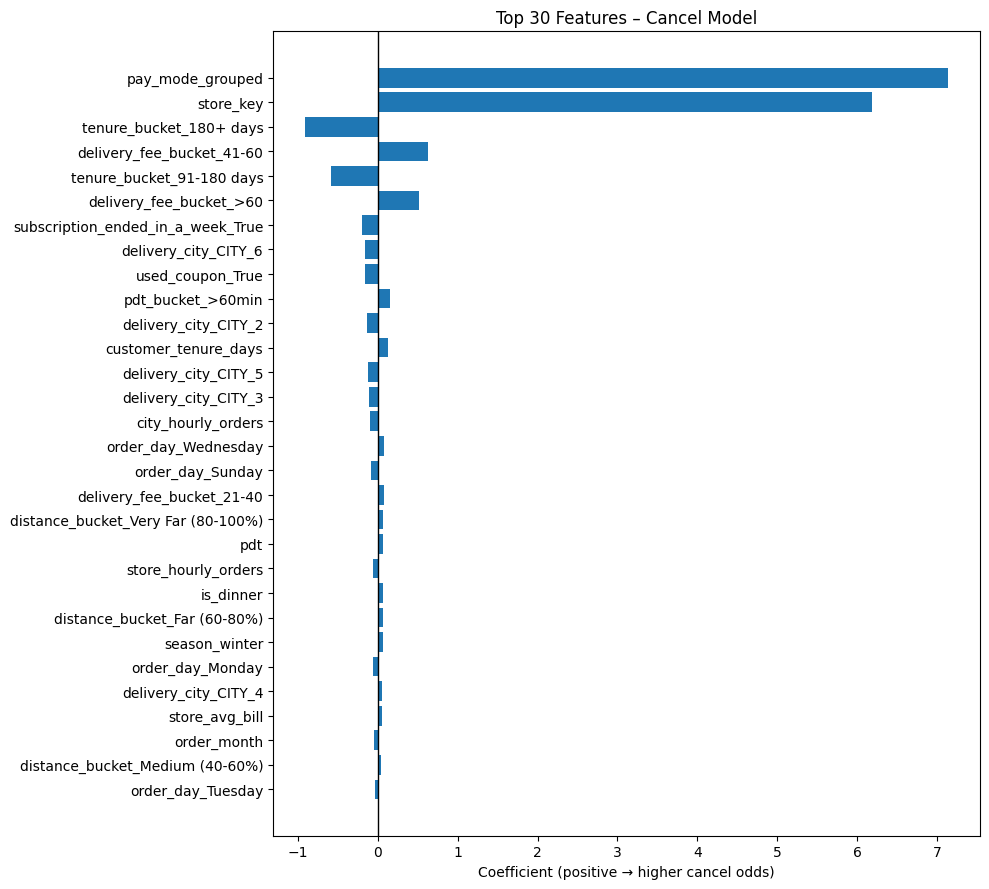

In [89]:
fi_df = get_logreg_feature_importance(best_model, meta)
fi_df.head(20)   # see top 20 important features

plot_top_features(fi_df, top_k=30, title="Top 30 Features – Cancel Model")


In [90]:
!pip install shap



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
row_eng = best_model.named_steps['row_eng']
group_eng = best_model.named_steps['group_eng']
preprocess = best_model.named_steps['preprocess']
clf = best_model.named_steps['clf']


In [92]:


# 1) background sample in raw space
X_bg = X_train.sample(n=200, random_state=42) if len(X_train) > 200 else X_train.copy()

# 2) apply row + group + preprocess
X_bg_row = row_eng.transform(X_bg)
X_bg_group = group_eng.transform(X_bg_row)
X_bg_trans = preprocess.transform(X_bg_group)   # this will be numpy array or sparse matrix


In [93]:
# 1) background sample in raw space
X_bg = X_train.sample(n=200, random_state=42) if len(X_train) > 200 else X_train.copy()

# 2) apply row + group + preprocess
X_bg_row = row_eng.transform(X_bg)
X_bg_group = group_eng.transform(X_bg_row)
X_bg_trans = preprocess.transform(X_bg_group)   # this will be numpy array or sparse matrix



In [94]:
explainer = shap.LinearExplainer(clf, X_bg_trans)

In [95]:
# test sample in raw space
X_test_sample = X_test.sample(n=200, random_state=42) if len(X_test) > 200 else X_test.copy()

# transform with same pipeline pieces
X_test_row = row_eng.transform(X_test_sample)
X_test_group = group_eng.transform(X_test_row)
X_test_trans = preprocess.transform(X_test_group)

# compute SHAP values in transformed space
shap_values = explainer(X_test_trans)   # shape: (n_samples, n_features)


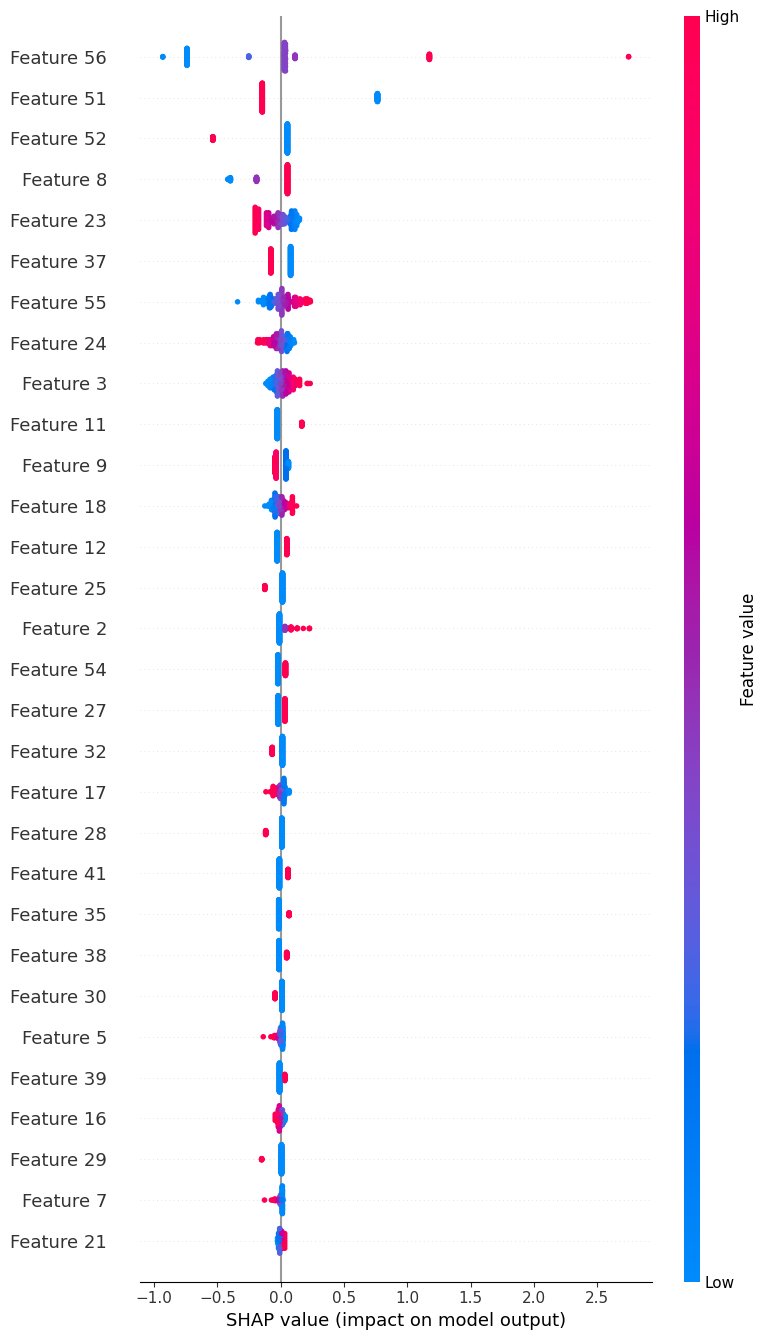

In [96]:
# convert sparse to dense if needed
if hasattr(X_test_trans, "toarray"):
    X_test_dense = X_test_trans.toarray()
else:
    X_test_dense = X_test_trans

shap.summary_plot(shap_values, X_test_dense, max_display=30)


In [97]:
def get_feature_names_from_preprocessor(preprocessor, meta=None):
    """
    Build a flat list of feature names after the ColumnTransformer.
    Works with:
      - num: SimpleImputer [+ optional PolynomialFeatures]
      - low_cat: OneHotEncoder
      - high_cat: TargetEncoder
    `meta` is optional now; we try to infer as much as possible from the fitted transformers.
    """
    feature_names = []

    # ---------- Numeric ----------
    if 'num' in preprocessor.named_transformers_:
        num_trans = preprocessor.named_transformers_['num']

        # Try to get original numeric column names
        if meta is not None and 'num_cols' in meta:
            num_cols = meta['num_cols']
        else:
            # fallback: use feature_names_in_ if present
            if hasattr(num_trans, 'feature_names_in_'):
                num_cols = list(num_trans.feature_names_in_)
            else:
                num_cols = []

        # If PolynomialFeatures present
        if 'interactions' in num_trans.named_steps:
            poly = num_trans.named_steps['interactions']
            if len(num_cols) > 0:
                num_feature_names = poly.get_feature_names_out(input_features=num_cols)
            else:
                num_feature_names = poly.get_feature_names_out()
        else:
            num_feature_names = np.array(num_cols)

        feature_names.extend(num_feature_names)

    # ---------- Low-cardinality categorical (OneHot) ----------
    if 'low_cat' in preprocessor.named_transformers_:
        low_cat_trans = preprocessor.named_transformers_['low_cat']
        ohe = low_cat_trans.named_steps['onehot']

        # IMPORTANT: don't pass input_features manually, let OHE use what it was fit on
        low_cat_feature_names = ohe.get_feature_names_out()
        feature_names.extend(low_cat_feature_names)

    # ---------- High-cardinality categorical (TargetEncoder) ----------
    if 'high_cat' in preprocessor.named_transformers_:
        high_cat_trans = preprocessor.named_transformers_['high_cat']

        # Try meta first
        if meta is not None and 'high_card_cat' in meta:
            high_cat_feature_names = np.array(meta['high_card_cat'])
        else:
            # fallback: use transformer's feature_names_in_ if available
            if hasattr(high_cat_trans, 'feature_names_in_'):
                high_cat_feature_names = np.array(high_cat_trans.feature_names_in_)
            else:
                high_cat_feature_names = np.array([])

        feature_names.extend(high_cat_feature_names)

    return np.array(feature_names)


n_shap_features: 57
n_x_features: 57
n_name_features: 57
Using min_feats = 57


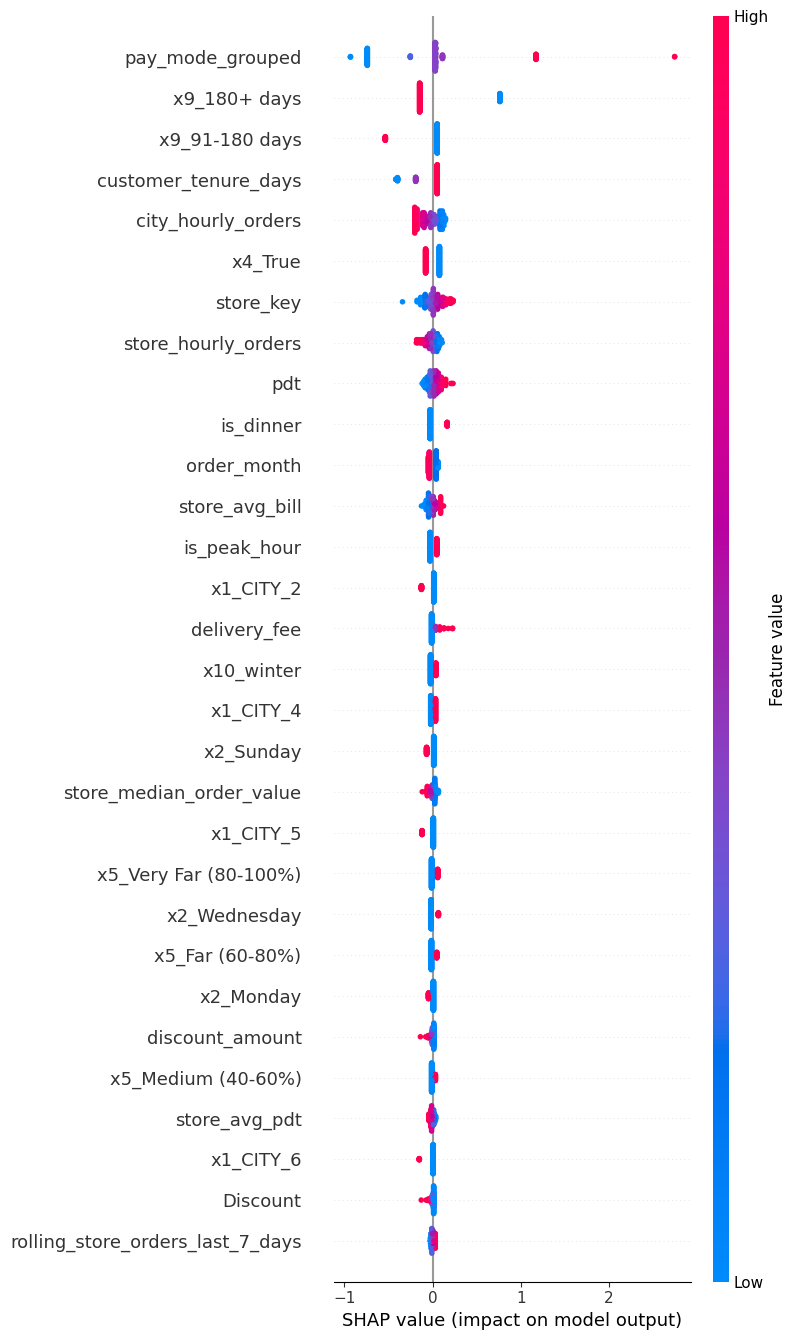

In [98]:
feature_names = get_feature_names_from_preprocessor(preprocess, meta)


# 1) Get SHAP values array (n_samples, n_features)
if hasattr(shap_values, "values"):
    shap_array = shap_values.values
else:
    shap_array = np.array(shap_values)

n_shap_features = shap_array.shape[1]
n_x_features = X_test_dense.shape[1]
n_name_features = len(feature_names)

print("n_shap_features:", n_shap_features)
print("n_x_features:", n_x_features)
print("n_name_features:", n_name_features)

# 2) Take the minimum across all three
min_feats = min(n_shap_features, n_x_features, n_name_features)
print("Using min_feats =", min_feats)

# 3) Trim everything to the same feature count
shap_array_trim = shap_array[:, :min_feats]
X_test_trim = X_test_dense[:, :min_feats]
feature_names_trim = np.array(feature_names)[:min_feats]

# 4) Plot with aligned shapes
shap.summary_plot(
    shap_array_trim,
    X_test_trim,
    feature_names=feature_names_trim,
    max_display=30
)



In [99]:
feature_names

array(['bill_amount', 'cart_amount', 'delivery_fee', 'pdt', 'order_hour',
       'discount_amount', 'manhattan_distance', 'Discount',
       'customer_tenure_days', 'order_month', 'is_lunch', 'is_dinner',
       'is_peak_hour', 'effective_cart_value',
       'discount_x_effective_cart_value', 'delivery_fee_x_distance',
       'store_avg_pdt', 'store_median_order_value', 'store_avg_bill',
       'store_order_count', 'store_peak_hour_load',
       'rolling_store_orders_last_7_days', 'store_long_distance_ratio',
       'city_hourly_orders', 'store_hourly_orders', 'x1_CITY_2',
       'x1_CITY_3', 'x1_CITY_4', 'x1_CITY_5', 'x1_CITY_6', 'x2_Monday',
       'x2_Saturday', 'x2_Sunday', 'x2_Thursday', 'x2_Tuesday',
       'x2_Wednesday', 'x3_True', 'x4_True', 'x5_Far (60-80%)',
       'x5_Medium (40-60%)', 'x5_Very Close (0-20%)',
       'x5_Very Far (80-100%)', 'x6_41-50min', 'x6_51-60min', 'x6_>60min',
       'x6_≤30min', 'x7_21-40', 'x7_41-60', 'x7_>60', 'x7_Free (0)',
       'x8_True', 'x9_